In [8]:
import torch
import torchvision
import torch.nn.functional as F
import torch.nn as nn
import snntorch as snn
from snntorch import spikegen
import matplotlib.pyplot as plt

from utils import printf, load_data
from models import *
from scripts import test_model
from attacks import fgsm_attack

# device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')

In [9]:
transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize(0,1)
])

batch_size = 32
dataset = 'fashion'

if dataset == 'fashion':
    categories = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
elif dataset == 'cifar':
    categories = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
else:
    categories = [x for x in range(10)]

train_dataset, train_loader = load_data(dataset, path='../data', batch_size=batch_size)
test_dataset, test_loader = load_data(dataset, path='../data', batch_size=batch_size, train=False)

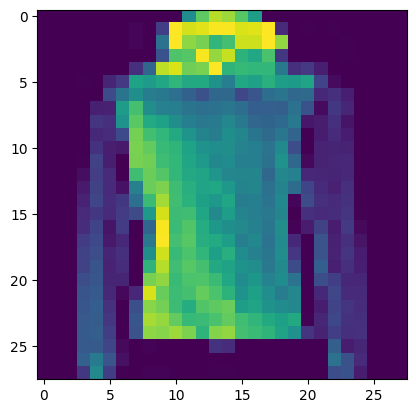

In [10]:
features, labels = next(iter(train_loader))
plt.imshow(features[0].permute(1,2,0))
plt.show()

# Loading Model

In [58]:
# ParaLIF
num_steps = 20
tau_mem = 0.02
tau_syn = 0.02
decay_rate = 0.
spike_mode = 'SB'

# model = SimpleSNN(28*28, num_steps=20) # MNIST or FashionMNIST
# model = LargerSNN(3*32*32, num_steps=20) # CIFAR-10
# model = LeNet5_CIFAR()
model = LeNet5_MNIST()
# model = SimpleParaLif(28*28, device=device, spike_mode=spike_mode, num_steps=num_steps, tau_mem=tau_mem, tau_syn=tau_syn) # MNIST
# model = testParaLIF(3*32*32, device=device, spike_mode=spike_mode, num_steps=num_steps, tau_mem=tau_mem, tau_syn=tau_syn) # CIFAR

In [7]:
# model = SimpleSNN(3*32*32, num_steps=10).to(device)

state_dict = torch.load('models/' + dataset.upper() + '-LeNet5-3-epochs' + '.pt')
if isinstance(model, SimpleSNN) or isinstance(model, LargerSNN):
    state_dict = {k: v for k, v in state_dict.items() if 'mem' not in k}
    model.load_state_dict(state_dict, strict=False)
else:
    model.load_state_dict(state_dict)

# Evaluation

In [7]:
test_model(model, loader=test_loader, device=device)

0.7499

# FGSM Attack

In [8]:
features, labels = next(iter(train_loader))
features, labels = features.to(device), labels.to(device)
perturbed, perturbed_output = fgsm_attack(model, nn.CrossEntropyLoss(), features, labels, epsilon=0.01)

In [9]:
model.eval()
predictions_on_perturbed = model(perturbed).argmax(dim=1)
predictions_on_originals = model(features).argmax(dim=1)

incorrect_indices = (predictions_on_perturbed != predictions_on_originals).nonzero().view(-1)
incorrect_indices

tensor([20, 31])

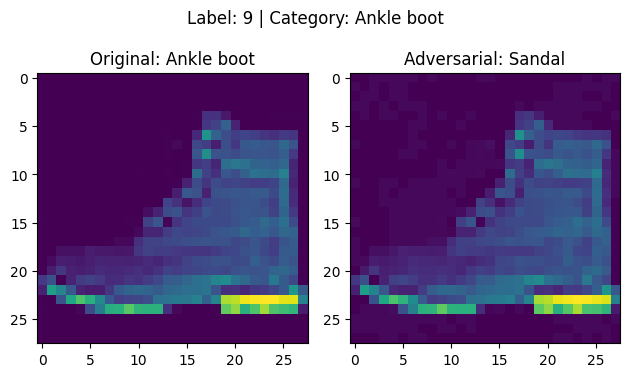

In [10]:
index = min(incorrect_indices)

fig, axs = plt.subplots(1,2)
axs[0].imshow(features[index, 0].detach().cpu())
axs[1].imshow(perturbed[index, 0].detach().cpu())
title = f" | Category: {categories[labels[index]]}"  if dataset == 'fashion' else ''
fig.suptitle(f'Label: {labels[index]}' + title)
axs[0].set_title(f'Original: {categories[predictions_on_originals[index]]}')
axs[1].set_title(f'Adversarial: {categories[predictions_on_perturbed[index]]}')
plt.tight_layout(); fig.subplots_adjust(top=1.1)
plt.show()

# FoolBox Attacks

In [44]:
import foolbox as fb

fmodel = fb.PyTorchModel(model, bounds=(0,1))

In [45]:
features, labels = next(iter(train_loader))
features, labels = features.to(device), labels.to(device)

attack = fb.attacks.LinfDeepFoolAttack()
raw, clipped, is_adv = attack(fmodel, features, labels, epsilons=0.01)

with torch.no_grad():
    model.eval()
    original_predictions = model(features).argmax(dim = -1)
    correct_prior_to_attack = (original_predictions ==  labels)
    adversarial_predictions = model(clipped).argmax(dim = -1)
    
indices_of_interest = (is_adv & correct_prior_to_attack).nonzero().view(-1)
index = indices_of_interest.min()

print(index)
print(indices_of_interest)

tensor(13)
tensor([13])


The attack returns three tensors.

1. The raw adversarial examples. This depends on the attack and we cannot make an guarantees about this output.

2. The clipped adversarial examples. These are guaranteed to not be perturbed more than epsilon and thus are the actual adversarial examples you want to visualize. Note that some of them might not actually switch the class. To know which samples are actually adversarial, you should look at the third tensor.

3. The third tensor contains a boolean for each sample, indicating which samples are true adversarials that are both misclassified and within the epsilon balls around the clean samples.

True: Pullover,
Predicted: Pullover,
Adversarial: Pullover


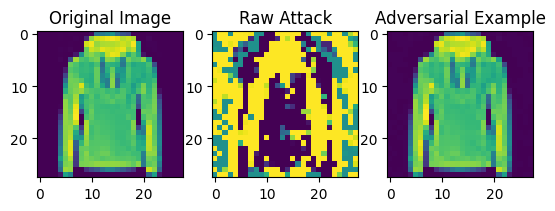

In [59]:
index = 13

fig, axs = plt.subplots(1,3)
axs[0].imshow(features[index].permute(1,2,0))
axs[1].imshow((clipped - features)[index].permute(1,2,0))
axs[2].imshow(clipped[index].permute(1,2,0))
axs[0].set_title('Original Image')
axs[1].set_title('Raw Attack')
axs[2].set_title('Adversarial Example')

print(f'True: {categories[labels[index]]},\nPredicted: {categories[original_predictions[index]]},\nAdversarial: {categories[adversarial_predictions[index]]}')

In [8]:
sum(p.numel() for p in model.parameters() if p.requires_grad)

567434

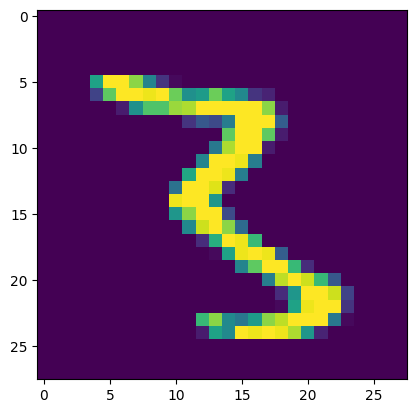

In [25]:
plt.imshow([0].permute(1,2,0))

# Impact of num_steps on robustness

In [5]:
import torch
import torchvision
from models import LeNet5_MNIST
from utils import load_data, printf, rate
import time
import foolbox as fb
from attacks import foolbox_attack

device = torch.device('mps' if torch.backends.mps.is_available() else 'cuda' if torch.cuda.is_available() else 'cpu')

def add_noise(features, n_steps):
    return rate(features, num_steps=n_steps).mean(dim=0)
 
def train_model(model, loader, optimizer, device, num_steps, n_epochs=20):
    criterion = torch.nn.CrossEntropyLoss()
    for epoch in range(n_epochs):
        model.train()
        n_correct, n_total = 0, 0
        for i, (features, labels) in enumerate(loader):
            features = add_noise(features, num_steps)
            
            features, labels = features.to(device), labels.to(device)
            output = model(features)
            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            correct = (output.argmax(dim = -1) == labels).sum().item()
            n_correct += correct
            n_total += len(labels)
            if (i + 1) % 20 == 0:
                printf(f'Epoch: [{epoch+1}/{n_epochs}], Batch: [{i+1}/{len(loader)}], Loss: {loss.item():.4f}, Training Accuracy: {correct/len(labels):.4f}, num_steps={num_steps}')
    return model

def test_model(model, loader, device, num_steps):
    with torch.no_grad():
        model.eval()
        n_correct, n_total = 0, 0
        
        for features, labels in loader:
            features = add_noise(features, num_steps)
            
            features, labels = features.to(device), labels.to(device)
            output = model(features)
            output = output.argmax(dim=-1)
            n_correct += (output == labels).sum().item()
            n_total += len(labels)
    
        return n_correct / n_total

def adv_attack(model_for_attack, attack):
    total = 0
    total_successful = 0

    for i, (images, labels) in enumerate(test_loader):
        
        images, labels = images.to(device), labels.to(device)
        raw_attack, perturbed_image, perturbed_prediction, original_prediction = foolbox_attack(model_for_attack, 
                                                                                                images=images, 
                                                                                                labels=labels, 
                                                                                                attack=attack, 
                                                                                                epsilons=0.01,
                                                                                                device=device)
        correct_pre_attack = (original_prediction == labels)
        correct_post_attack = (perturbed_prediction == labels)
        
        total += correct_pre_attack.sum().item()
        
        if raw_attack is None: # no attack found    
            continue
        
        successful_attack_indices = (correct_pre_attack & ~correct_post_attack).view(-1)
        n_successful_attacks = successful_attack_indices.sum().item()
        printf(f'Batch: [{i}/{len(test_loader)}], ' 
            + f'Successful Attacks: [{n_successful_attacks}/{correct_pre_attack.sum().item()}],'
            + f'Batch Model Accuracy: [{correct_pre_attack.sum().item()}/{len(labels)}]')
        
        total_successful += n_successful_attacks
    return total_successful / total


In [3]:
##### Hyperparameters #####

batch_size = 256
learning_rate = 0.01 # use 0.001 for ParaLIF

optimizer = torch.optim.SGD # Best for SimpleSNN
# optimizer = torch.optim.Adam # NOTE: Adam doesn't seem to perform well on CIFAR with SimpleSNN
# optimizer = torch.optim.Adamax # Best for ParaLIF


##### Options #####

dataset = 'fashion' # ['mnist', 'cifar', 'fashion']
attack = fb.attacks.LinfFastGradientAttack()

##### Data #####

transforms = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Normalize((0,0,0), (1,1,1)) if dataset == 'cifar' else torchvision.transforms.Normalize(0, 1)
])

train_dataset, train_loader = load_data(dataset=dataset, path='../data', train=True, batch_size=batch_size, transforms=transforms)
test_dataset, test_loader = load_data(dataset=dataset, path='../data', train=False, batch_size=batch_size, transforms=transforms)

In [9]:
steps = [3, 5, 10] #[1, 3, 5, 10, 20, 30, 50, 100]
train_accuracy = []
test_accuracy = []
attack_susceptibility = []

n_epochs = 20

for n_steps in steps:
    

    model = LeNet5_MNIST().to(device)
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

    start_time = time.time()
    model = train_model(model, loader=train_loader, optimizer=optimizer,device=device,num_steps=n_steps, n_epochs=5)
    
    print(f'\nTraining time: {time.time() - start_time:.1f} seconds.')
    print('\n---------- Testing ----------\n')

    train_accuracy.append(test_model(model, loader=train_loader, device=device, num_steps=n_steps))
    test_accuracy.append(test_model(model, loader=test_loader, device=device, num_steps=n_steps))
    attack_susceptibility.append(adv_attack(model, attack=attack))

Batch: [39/40], Successful Attacks: [2/13],Batch Model Accuracy: [13/16]

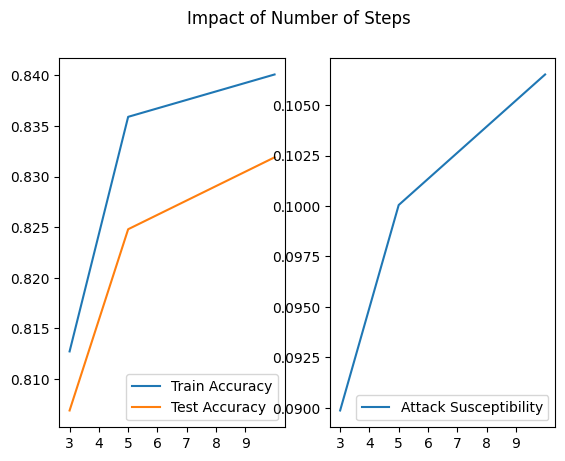

In [24]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2)
axs[0].plot(steps, train_accuracy, label = 'Train Accuracy')
axs[0].plot(steps, test_accuracy, label='Test Accuracy')
axs[0].legend(loc='lower right')
axs[1].plot(steps, attack_susceptibility, label='Attack Susceptibility')
axs[1].legend(loc='lower right')
plt.suptitle('Impact of Number of Steps')
axs[0].set_xticks(torch.arange(min(steps), max(steps)))
axs[1].set_xticks(torch.arange(min(steps), max(steps)))
plt.show()